# Ciência dos Dados - 2020 / Segundo Semestre

## Projeto 2

# Entrega 1

In [ ]:
import pandas as pd
import csv
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

"""
Grupo:
Carlos Simodo
Lai Aguiar

Abre csv disponível no repositório https://github.com/seade-R/dados-covid-sp
público com dados da covid no estado de São Paulo
"""
data = pd.read_csv('casos_obitos_doencas_preexistentes.csv', sep=';')


# Eliminamos a coluna codigo_ibge por ela não nos trazer uma informação relevante,
# já que trabalhamos com a probabilidade de óbito a partir de comorbidades, local
# de diagnóstico, idade, sexo 
del data['codigo_ibge']

# Eliminamos as linhas da tabela onde temos informações repetidas e 
# incoerentes como idade = 120 anos
# Também eliminamos todos identificadores IGNORADO ou vazios
data = data[data['idade'] < 120]

data = data.applymap(lambda x: np.nan if x == 'IGNORADO' else x).dropna()
# data = data[data != np.nan()]
# data = data.replace('IGNORADO', 'NÃO')
# data = data.replace('NaN', 'NÃO')

data.to_csv('casos_obitos_doencas_preexistentes_tratado.csv', sep=';')



data_copy = data.copy()
train = data_copy.sample(frac=0.75, random_state=0)
test = data_copy.drop(train.index)


# Entrega 2

#### Para analisarmos os dados, decidimos começar pela idade para ter uma ideia do perfil dos entrevistados

In [ ]:
media_idade = data['idade'].mean()
mediana_idade = data['idade'].median()
moda_idade = data['idade'].mode()
var_idade = data['idade'].var()
std_idade = data['idade'].std()

print('A média de idade no nosso dataset é :', media_idade, '')
print('A variância da idade no nosso dataset é: ', var_idade)
print('O desvio padrão da idade no nosso dataset é: ', std_idade, 'que significa que os dados não estão muito espalhados')
print('A mediana da idade no nosso dataset é: ', mediana_idade)
print('A moda de idade no nosso dataset é: ', moda_idade, 'uma idade alta muito frequente')

A média de idade no nosso dataset é : 62.72689380210221 
A variância da idade no nosso dataset é:  282.08110004708567
O desvio padrão da idade no nosso dataset é:  16.795270168922134 que significa que os dados não estão muito espalhados
A mediana da idade no nosso dataset é:  64.0
A moda de idade no nosso dataset é:  0    70.0
dtype: float64 uma idade alta muito frequente


#### Percebemos que tanto a idade média quanto a mediana e a moda estão muito altas, indicando que a maioria dos entrevistados possuem idades elevadas.Tendo analisado um pouco sobre os entrevistados, decidimos verificar a influência de cada doenca pré existente com o óbito.

In [ ]:
data_temp = data.replace({'NÃO': 0, 'SIM': 1})
print(data_temp.corr())

                            idade     obito  ...  puerpera  sindrome_de_down
idade                    1.000000  0.317506  ... -0.043152         -0.037831
obito                    0.317506  1.000000  ... -0.016626         -0.008298
asma                    -0.086396 -0.043465  ...  0.000666         -0.002162
cardiopatia              0.239319  0.071243  ... -0.028978         -0.009117
diabetes                 0.096856  0.035643  ... -0.033648         -0.003749
doenca_hematologica     -0.010112  0.035903  ...  0.017625          0.059561
doenca_hepatica         -0.020659  0.035517  ... -0.007625          0.035274
doenca_neurologica       0.155402  0.132156  ... -0.006152          0.021346
doenca_renal             0.055345  0.079080  ... -0.004828          0.024038
imunodepressao          -0.029915  0.061633  ...  0.001869          0.012351
obesidade               -0.180636 -0.019185  ... -0.000527         -0.004642
outros_fatores_de_risco -0.009685  0.044120  ... -0.013735         -0.013074

#### Com a matriz de correlação, podemos visualizar a correlação entre as doencas e o numero de mortos. Embora gráficos de dispersão sejam ótimas ferramentas para isso, decidimos nao plotar gráficos com o scatter plot, uma vez que ele é melhor para variáveis continuas, e nossos dados são em sua maioria variáveis binárias

#### Tendo descoberta as correlações, buscamos descobrir a prevalencia das doenças nos entrevistados, e para isso utilizamos gráficos de setores(pizza) para termos uma ideia mais geral, apenas da proporção.

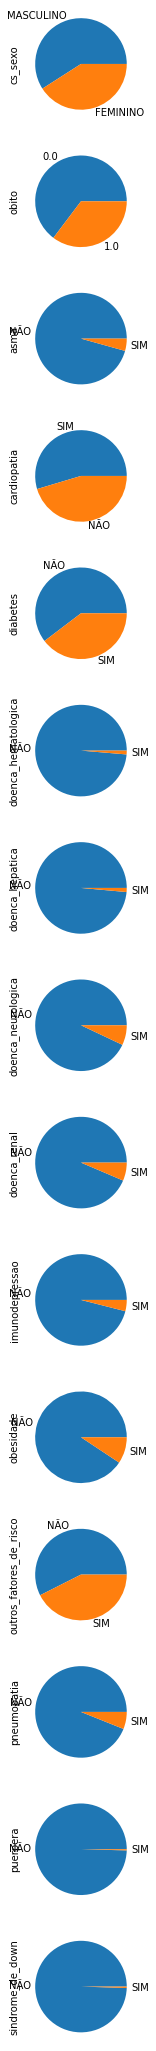

In [ ]:
plt.figure()
i=1
#print(data.columns)
#lista para retirar dados que não pertecem a essa parte da analise
lista_no_plot = ['nome_munic', 'idade', 'data_inicio_sintomas','diagnostico_covid19']
for item in data.columns:
  if item not in (lista_no_plot):
    a = plt.subplot(16,1,i)
    temp_frame = data[item].value_counts()
    plot = temp_frame.plot.pie(y=item, figsize=(40, 40),ax=a)
    i+=1
  

#### Com os dados obtidos acima, temos uma noção do perfil dos pacientes,que possuem em media uma idade mais elevada e são em sua maioria homens, da prevalencia das doenças,sendo a mais comum a cardiopatia, e a correlação que essas doencas posssuem com a morte, que afetou cerca de um terço dos entrevistados. Assim, consideramos que a análise inicial está completa.


### Entrega 3

In [ ]:
obitou = train[train['obito']==1]
viveu = train[train['obito'] != 1]

# probabilidades de ter cada doenca, dado que morreu
dict_doenca_morreu = dict()
for column in obitou.columns:
    if column not in (lista_no_plot):
        dict_doenca_morreu[column] = len(obitou[obitou[column]=='SIM'])/len(obitou)

# probabilidades de ter cada doenca, dado que sobreviveu
dict_doenca_viveu = dict()
for column in viveu.columns:
    if column not in (lista_no_plot):
        dict_doenca_viveu[column] = len(viveu[viveu[column]=='SIM'])/len(viveu)

# probabilidade de ter a doenca
dict_doenca = dict()
for column in train.columns:
    if column not in (lista_no_plot):
        dict_doenca[column] = len(train[train[column]=='SIM'])/len(data)

# probabilidade de morrer do covid
prob_morrer = len(obitou)/len(train)
prob_viver = 1 - prob_morrer

# calculo da probabilidade de morrer dado que tem uma doenca
# Aqui foio calculada a probabilidade independente, porém sabemos que não é o cálculo definitivo,
# pois precisamos da probabilidade combinada
prob_bayes = dict()
for doenca in train.columns:
    if doenca not in (lista_no_plot):
        if dict_doenca[doenca]>0:
            prob_bayes[doenca] = dict_doenca_morreu[doenca]*prob_morrer / dict_doenca[doenca]
        else: prob_bayes[doenca] = 0


# prob final

def calcula(lista_doenca):
    multip = prob_morrer
    cte_normalizadora_v = prob_viver
    cte_normalizadora_m = prob_morrer

    for doenca in lista_doenca:
        multip = multip*dict_doenca_morreu[doenca]
        cte_normalizadora_v  = cte_normalizadora_v*dict_doenca_viveu[doenca]
        cte_normalizadora_m  = cte_normalizadora_m*dict_doenca_morreu[doenca]
    
    cte_normalizadora = cte_normalizadora_v + cte_normalizadora_m
    prob_final = multip/cte_normalizadora

    return prob_final

# Teste da função de calculo da probabilidade de óbito

# pacientes = {'paciente 1': ['cardiopatia', 'pneumopatia'],
#              'paciente 2': ['asma', 'diabetes', 'imunodepressao', 'cardiopatia'],
#              'paciente 3': ['pneumopatia']}


# for paciente in pacientes.keys():
#     print("A probabilidade do {} morrer, dado que ele tem {} é de {}".format(paciente, str(pacientes[paciente])[1:-1].replace("""'""", ""), calcula(pacientes[paciente])))


df = data
columns = data.columns

lista_prob=[]

for index, row in df.iterrows(): 
    lista_variaveis = []
    row['prob'] = 0
    for column in columns:
       if column not in lista_no_plot:
            if row[column] == 'SIM':
              lista_variaveis.append(column)
    lista_prob.append(float(calcula(lista_variaveis)))


df['Probabilidade'] = lista_prob

#def verifica_morte(prob):
#  alfa=0.559
#  if prob>alfa:
#    return 'SIM'
#  else:
#    return 'NÃO'


# alfa = 0.7
# df["Classificacao"] = df["Probabilidade"].apply(verifica_morte)
# df

In [19]:
def verifica_alfa(prob):
  if prob>alfa:
    return 'SIM'
  else:
    return 'NÃO'

alfa = 0.05
delta = 0.001
melhor = [alfa, 0]
accur = 0.0

while alfa <= 1.0:
  df["Classificacao"] = df["Probabilidade"].apply(verifica_alfa)
  df = df.replace({0: 'NÃO', 1: 'SIM'})
  # cross_tab = pd.crosstab(df.obito,df.Classificacao, normalize="columns")*100
  
  acerto = df[df['obito']==df['Classificacao']]
  accur = round(len(acerto)/len(df), 3)*100

  if accur > melhor[0]:
    melhor = [alfa, round(accur, 3)]  

  # print('Para o threshold {} a acurácia do modelo é de {}%'.format(alfa, accur))

  alfa += delta

print('Para o threshold 0.559 a acurácia do modelo é de 66.1%. A melhor encontrada.')

#print(melhor)

Para o threshold 0.559 a acurácia do modelo é de 66.1%. A melhor encontrada.


In [21]:
# Calculo das probabilidades com o dataset de teste
df = df.replace({0: 'NÃO', 1: 'SIM'})
pd.crosstab(df.obito,df.Classificacao, normalize="columns")*100


Classificacao,NÃO
obito,
NÃO,64.715477
SIM,35.284523


In [ ]:
from sklearn.linear_model import LinearRegression


data_copy = data.copy()
train = data_copy.sample(frac=0.75, random_state=0)
test = data_copy.drop(train.index)

train_y = train['obito']
del train['obito']
del train['nome_munic']
del train['cs_sexo']
del train['diagnostico_covid19']
del train['data_inicio_sintomas']
train = train.replace({'NÃO': 0, 'SIM': 1})


test_y = test['obito']
del test['obito']
del test['nome_munic']
del test['cs_sexo']
del test['diagnostico_covid19']
del test['data_inicio_sintomas']
test = test.replace({'NÃO': 0, 'SIM': 1})

model = LinearRegression()
model.fit(train, train_y)
model = LinearRegression().fit(train, train_y)



model.score(train, train_y)



0.13644241175378657

In [23]:
from sklearn import svm
from sklearn import metrics


data_copy = data.copy()
train = data_copy.sample(frac=0.75, random_state=0)
test = data_copy.drop(train.index)

X_test = test.replace({'NÃO': 0, 'SIM': 1})
Y_test = test['obito']
del X_test['obito']
del X_test['nome_munic']
del X_test['cs_sexo']
del X_test['diagnostico_covid19']
del X_test['data_inicio_sintomas']

X_train = train.replace({'NÃO': 0, 'SIM': 1})
Y_train = X_train['obito']
del X_train['obito']
del X_train['nome_munic']
del X_train['cs_sexo']
del X_train['diagnostico_covid19']
del X_train['data_inicio_sintomas']


#Cria um classificador baseado no "Support vector machine"
clf = svm.SVC(kernel='linear') # Linear Kernel

#Treina o modelo usando os dados determinados previamente
clf.fit(X_train, Y_train)

#Realiza a previsao no conjunto de teste
Y_pred = clf.predict(X_test)

print("Accurácia:",metrics.accuracy_score(Y_test, Y_pred))

# Precisão do modelo : quantas das classificações de classe Positivo que o modelo fez estão corretas?
print("Precisão:",metrics.precision_score(Y_test, Y_pred))

# Recall do modelo: quantas das situações com classe Positivo como valor esperado  estão corretas;?
print("Recall:",metrics.recall_score(Y_test, Y_pred))


Accurácia: 0.6710144927536232
Precisão: 0.5802469135802469
Recall: 0.19583333333333333


https://stats.stackexchange.com/questions/89914/building-a-classification-model-for-strictly-binary-data


referencia
